In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('adult.data', header=None, names=columns, na_values=' ?')
# Удаляем колонку education (потому что есть уже закодированная колонка education-num)
df = df.drop('education', axis=1)
# Кодируем отклик в бинарные значения
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
# удаляем строки с NA значениями
df = df.dropna()

test = pd.read_csv('adult.test', header=None, names=columns, na_values=' ?', skiprows=1)
test = test.drop('education', axis=1)
test['income'] = test['income'].map({' <=50K.': 0, ' >50K.': 1})
test = test.dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'adult.data'

In [ ]:
df.head()

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Посчитаем распределение классов в отклике.

In [ ]:
df['income'].value_counts(normalize=True)

0    0.751078
1    0.248922
Name: income, dtype: float64

Разбиваем выборку на обучающую и тестовую. 

In [ ]:
X_train = pd.get_dummies(df).drop('income', axis=1)
y_train = df['income']



Бинаризуем категориальные признаки (эта операция ещё называется one-hot encoding).

In [ ]:
X_test = pd.get_dummies(test).drop('income', axis=1)
y_test = test['income']

После бинаризации категориальных признаков оказалось, что в обучающем множестве содержится на одну колонку больше. Причина: в тестовую выборку не попал ни один представитель Голландии (см. колонку native-county). Проверяем

In [ ]:
print (len(X_train.columns))
print (len(X_test.columns))
# Приводим множество названий колонок к типу set, находим разность двух множеств.
print(set(X_train.columns) - set(X_test.columns))
print(set(X_test.columns) - set(X_train.columns))

88
87
{'native-country_ Holand-Netherlands'}
set()


Исправляем. 
Создадим полный список всех колонок (из трейна и из теста) и переиндексируем колонки в соответствии с этим списком. В результате в колонке native-country_ Holand-Netherlands в тестовом множестве появятся NaN-значения, которые мы заменим на нули.

In [ ]:
columns = set(X_train.columns) | set(X_test.columns)
X_train = X_train.reindex(columns=columns).fillna(0)
X_test = X_test.reindex(columns=columns).fillna(0)

Теперь колонки в обучающей и тестовой выборках должны быть идентичными. 
В том числе идентичным должен быть и порядок колонок. 
На всякий случай проверим.

In [ ]:
# Команда all проверяет, все ли значения из входного списка равны True
all(X_train.columns == X_test.columns)

True

Перейдём, наконец, к обучению модели.


XGBoost

In [ ]:
from sklearn.metrics import classification_report

# conda install py-xgboost
# conda install -c anaconda py-xgboost  -- появилась Teano
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(n_estimators=100,
                      max_depth=3,
                      learning_rate=0.3,
                      verbosity=1,
                      objective="binary:logistic",
                      booster='gbtree',
                      gamma=0, # min tree loss
                      min_child_weight=1,  # min sum of child
                      max_delta_step=0, # 0 - no constraint
                      subsample=1, 
                      reg_alpha=0, # l1
                      reg_lambda=1, # l2
                      scale_pos_weight=1,
                      base_score=0.5
                      )

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
print (classification_report(y_train, y_pred_train))

y_pred = model.predict(X_test)
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92     22654
           1       0.80      0.66      0.73      7508

    accuracy                           0.88     30162
   macro avg       0.85      0.81      0.82     30162
weighted avg       0.87      0.88      0.87     30162

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     11360
           1       0.79      0.66      0.72      3700

    accuracy                           0.87     15060
   macro avg       0.84      0.80      0.82     15060
weighted avg       0.87      0.87      0.87     15060



In [ ]:
import seaborn as sns
sns.set(font_scale = 1.5)

In [ ]:
import xgboost as xgb


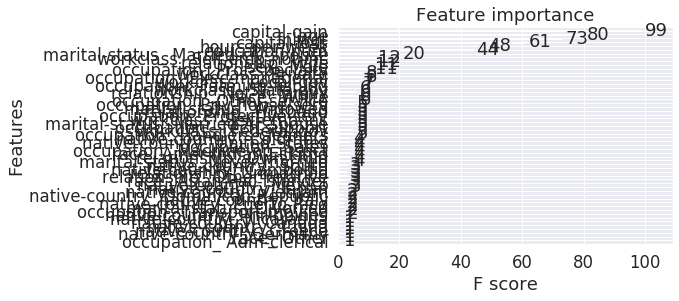

In [ ]:
xgb.plot_importance(model)

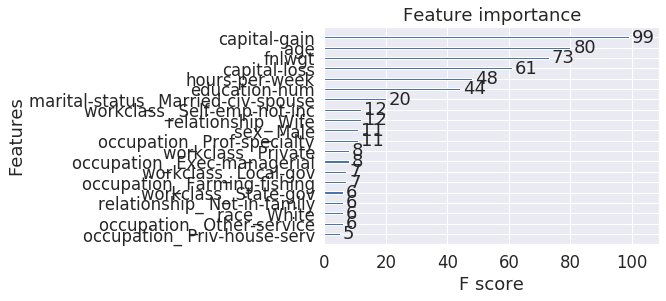

In [ ]:
xgb.plot_importance(model, max_num_features = 20)


